<a href="https://colab.research.google.com/gist/nazmi/038f6163a558e903227f48e20a47e709/tsp-cv-baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [ ]:
import sys
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
import wandb
from wandb.keras import WandbCallback
run = wandb.init(project="tsp-cv", save_code=True)

In [ ]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ['TF_ENABLE_AUTO_MIXED_PRECISION'] = '1'
os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tf.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
if gpus:
    for gpu in gpus:
        print(tf.config.experimental.get_device_details(gpu))
else:
    print("GPU is NOT AVAILABLE")



# Fetch dataset

In [ ]:
PATH = "dataset/"
PATH_TRAIN =os.path.join(PATH,"train.csv")
PATH_TEST = os.path.join(PATH,"test.csv")

if not os.path.exists(PATH):
    !kaggle competitions download -c tsp-cv
    with zipfile.ZipFile("tsp-cv.zip", 'r') as zip_ref:
        zip_ref.extractall(path=PATH)
        zip_ref.close()

In [46]:
train_df = pd.read_csv(PATH_TRAIN)
test_df = pd.read_csv(PATH_TEST)
train_df.head()

,id,filename,distance
0,0,0.jpg,83110
1,1,1.jpg,1035
2,2,2.jpg,20756
3,3,3.jpg,13286
4,4,4.jpg,13924


## Split dataset

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df["filename"].values, train_df["distance"].values,
                                                    test_size=0.2, train_size=0.8,
                                                    random_state=42)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler(feature_range=(0,1000))
y_train_scaled = minmax_scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()
y_test_scaled = minmax_scaler.transform(y_test.reshape(-1, 1)).squeeze()

## Visualize dataset

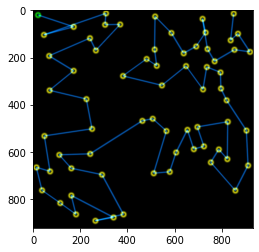

In [47]:
import matplotlib.image as mpimg
import random

rand = random.randrange(len(X_train))
img = mpimg.imread(os.path.join(PATH, X_train[rand]))
plt.imshow(img)

# Preprocesssing

## tf.data pipeline

In [ ]:
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

tf.random.set_seed(42)
IMG_SIZE = 320
BATCH_SIZE = 16

@tf.function
def read_image(image):
    with tf.device('/device:GPU:0'):
      image = tf.io.read_file(PATH + image)
      image = tf.io.decode_jpeg(image, channels=3, dct_method='INTEGER_ACCURATE')
      image = tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE)
      return image


def rescale(image):

    rescale = tf.keras.Sequential([
        layers.Rescaling(scale=1./127.5, offset=-1)
    ])

    image = rescale(image)

    return image


def augmentation(image):

    augment = tf.keras.Sequential([
        layers.RandomFlip()
    ])

    image = augment(image)

    return image


def prepare(ds, shuffle=False, repeat=False, cache=False, scale=False, augment=False, batch_size=BATCH_SIZE):

    # Applying normalization before `ds.cache()` to re-use it.
    # Note: Random transformations (e.g. images augmentations) should be applied
    # after both `ds.cache()` (to avoid caching randomness) and `ds.batch()` (for
    # vectorization [1]).

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    if repeat:
        ds = ds.repeat()

    ds = ds.map(lambda x, y: (read_image(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    # Batch after shuffling to get unique batches at each epoch.
    ds = ds.batch(batch_size, num_parallel_calls=tf.data.AUTOTUNE)
    
    
    if augment:
        ds = ds.map(lambda x, y: (augmentation(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    if scale:
        ds = ds.map(lambda x, y: (rescale(x), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    if cache:
        ds = ds.cache()

    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_data = prepare(train_data, scale=True, shuffle=True,augment=True)

valid_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_data = prepare(valid_data, scale=True)

train_data_scaled = tf.data.Dataset.from_tensor_slices((X_train, y_train_scaled))
train_data_scaled = prepare(train_data_scaled, scale=True, shuffle=True,augment=True,cache=True)

valid_data_scaled = tf.data.Dataset.from_tensor_slices((X_test, y_test_scaled))
valid_data_scaled = prepare(valid_data_scaled, scale=True,cache=True)

In [ ]:
for image, label in train_data.take(1):
    print(image.shape, label.shape)
    print(image.dtype)
    print(f" Min: {tf.reduce_min(image[0])} Max: {tf.reduce_max(image[0])}")
    plt.imshow(tf.cast((image[0]+1)/2,dtype=tf.float32))
    print(f" Distance: {label[0]}")

# Create Model

In [ ]:
from tensorflow.keras.metrics import RootMeanSquaredError

input_shape = (IMG_SIZE, IMG_SIZE,3)
inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float32)

x = layers.Conv2D(32, 3, activation="relu")(inputs)
x = layers.Conv2D(64, 3, activation="relu")(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(2048, activation="relu")(x)
x = layers.Dense(2048, activation="relu")(x)

outputs = layers.Dense(1,activation="linear", name="output_layer",dtype=tf.float32)(x)
model = models.Model(inputs, outputs)



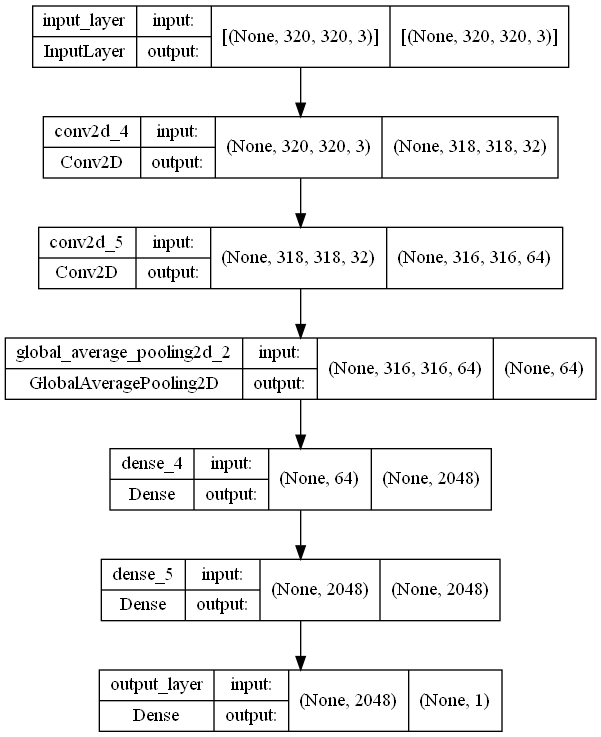

In [52]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
import datetime
LEARNING_RATE = 3e-3
EPOCHS = 2000


stop_callback = callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-4,
                                        patience=25, verbose=1, mode='auto',
                                        restore_best_weights=True)

lr_callback = callbacks.ReduceLROnPlateau(monitor='loss',
                                          factor=0.2, min_lr=1e-9, patience=2)

log_dir = "logs/tsp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_callback = callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                             profile_batch='500,520')

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss="mse",
              metrics=[RootMeanSquaredError(name="rmse")])

In [49]:
model.load_weights("checkpoint/baseline/")

In [ ]:
wandb.config = {
  "learning_rate": LEARNING_RATE,
  "epochs": EPOCHS
}

history = (
    model.fit(
        train_data_scaled,
        epochs=EPOCHS,
        validation_data=valid_data_scaled,
        callbacks=[stop_callback, lr_callback, WandbCallback()]
    )
)

In [ ]:
def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics.
    Args:
      history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['rmse']
    val_accuracy = history.history['val_rmse']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

    
plot_loss_curves(history)

# Evaluate

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error


def calculate_results(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    max_err = max_error(y_true, y_pred)

    model_results = {"Mean Absolute Error": mae,
                     "Mean Square Error": mse,
                     "Root Mean Square Error": np.sqrt(mse),
                     "Max Error": max_err}

    wandb.log({"valid_mae": mae,
        "valid_mse": mse,
        "valid_rmse": np.sqrt(mse),
        "valid_err": max_err})

    return model_results

def calculate_results_scaled(y_true, y_pred):
    inv_y_true = minmax_scaler.inverse_transform(y_true.reshape(-1, 1))
    inv_y_pred = minmax_scaler.inverse_transform(y_pred.reshape(-1, 1))
    model_results = calculate_results(inv_y_true, inv_y_pred)
    
    return model_results


In [53]:
model_pred_probs = model.predict(valid_data_scaled)
model_results = calculate_results_scaled(y_test_scaled, model_pred_probs)


In [54]:
model_results

{'Mean Absolute Error': 178.7817050586181,
 'Mean Square Error': 180230.19558356132,
 'Root Mean Square Error': 424.5352701290687,
 'Max Error': 8884.5859375}

# Top 10% Wrong

In [55]:
inv_y_test = minmax_scaler.inverse_transform(y_test_scaled.reshape(-1, 1)).squeeze()
inv_y_pred = minmax_scaler.inverse_transform(model_pred_probs.reshape(-1, 1)).squeeze()
error = (inv_y_test - inv_y_pred).squeeze()
square_error = np.square(error)

validation_df = pd.DataFrame({'true': inv_y_test,
                             'pred': inv_y_pred,
                             'error': error,
                             'square_error': square_error})



In [56]:
top_100_wrong = validation_df.sort_values("error", ascending=False).head(100)
top_100_wrong

,true,pred,error,square_error
2143,143577.0,140174.171875,3402.828125,1.157924e+07
2081,132234.0,129023.101562,3210.898438,1.030987e+07
2960,112477.0,109358.781250,3118.218750,9.723288e+06
2298,102932.0,100047.187500,2884.812500,8.322143e+06
2112,138047.0,135210.640625,2836.359375,8.044935e+06
...,...,...,...,...
2795,86306.0,85770.375000,535.625000,2.868941e+05
1152,19436.0,18902.011719,533.988281,2.851435e+05
1303,36085.0,35551.671875,533.328125,2.844389e+05
3104,106622.0,106089.468750,532.531250,2.835895e+05


# Prediction

In [ ]:

def prepare(ds, shuffle=False, repeat=False, cache=False,scale=False,augment=False):

# Applying normalization before `ds.cache()` to re-use it.
# Note: Random transformations (e.g. images augmentations) should be applied
# after both `ds.cache()` (to avoid caching randomness) and `ds.batch()` (for
# vectorization [1]).

    ds = ds.map(read_image, num_parallel_calls=tf.data.AUTOTUNE)

    if cache:
        ds = ds.cache()
        
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    if repeat:
        ds = ds.repeat()

    # Batch after shuffling to get unique batches at each epoch.
    ds = ds.batch(BATCH_SIZE,num_parallel_calls=tf.data.AUTOTUNE)

    if augment:
        ds = ds.map(augmentation, num_parallel_calls=tf.data.AUTOTUNE)
        
    if scale:
        ds = ds.map(rescale, num_parallel_calls=tf.data.AUTOTUNE)

    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
test_data = tf.data.Dataset.from_tensor_slices(test_df["filename"].values)
test_data = prepare(test_data, scale=True)

In [57]:
model_predictions = model.predict(test_data)
model_predictions = minmax_scaler.inverse_transform(model_predictions)


In [58]:
model_predictions

array([[ 8301.726],
       [55711.125],
       [11562.893],
       ...,
       [11381.534],
       [16238.359],
       [12262.215]], dtype=float32)

In [60]:
submission_df = pd.DataFrame({"id": test_df["id"], "distance": model_predictions.squeeze()})

submission_df.to_csv("submission-baseline.csv", index=False)

In [ ]:
wandb.alert(title="Finished", text=f"Training has finished training", level=wandb.AlertLevel.INFO)
wandb.finish()